#####Pemrosesan Bahasa Alami
#Malware Classification
##Dibuat Oleh:
- Adhitya Primandhika	
- Hafidz Arifudin		  


##Import library

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from zipfile import ZipFile
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

Untuk mengetahui model mana yang akan digunakan, terlebih dahulu mengidentifikasi masing-masing algoritma sehingga akan didapatkan algoritma yang paling cocok untuk kasus ini. Maka dari itu, banyak algoritma yang harus diimport librarynya menggunakan library sklearn.

Dokumen yang diperlukan untuk melakukan Malware Classification adalah Train.csv, Test.csv, dan LOGS.zip. Untuk menjalankannya kita perlu memasukkan/mengunggah ketiga file tersebut.

##Membuat dataframe untuk data train dan data test menggunakan library pandas

In [ ]:
train_df = pd.read_csv("Train.csv", names=["Sample","Class"])
train_df.head()

,Sample,Class
0,3533,2
1,1270,5
2,3270,1
3,1323,2
4,1064,2


In [ ]:
test_df = pd.read_csv("Test.csv", names=["Sample"])
test_df.head()

,Sample
0,54
1,1460
2,1312
3,1230
4,3077


In [ ]:
labeled_df = pd.read_csv("test_labeled.csv", names=["Sample", "Class"])
labeled_df.head()

,Sample,Class
0,54,2
1,1460,1
2,1312,2
3,1230,1
4,3077,2


##Melihat sebaran feature class yang ada pada data train

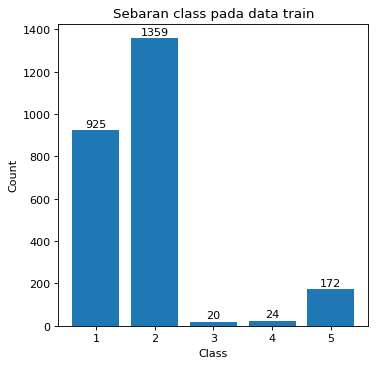

In [ ]:
def labels(x,y):
    for i in range(len(x)):
        plt.text(i+1, y[i]+15, y[i], ha = 'center')
plt.figure(figsize=(5,5), dpi=80)
plt.bar(train_df["Class"].value_counts().sort_index().index.tolist(), train_df.groupby('Class')["Sample"].nunique().tolist())
labels(train_df["Class"].value_counts().sort_index().index.tolist(), train_df.groupby('Class')["Sample"].nunique().tolist())
plt.title('Sebaran class pada data train')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Terlihat bahwa Class 2 merupakan yang terbanyak dengan jumlah 1359, sedangkan Class 3 merupakan yang paling sedikit dengan jumlah 20.

##Membuat list dari nama file yang nantinya akan dibaca untuk data train dan test

In [ ]:
train_list = []
for sample in train_df["Sample"]:
  temp = str(sample).zfill(4) + ".seq"
  train_list.append(temp)
print(train_list)

['3533.seq', '1270.seq', '3270.seq', '1323.seq', '1064.seq', '3015.seq', '3985.seq', '0032.seq', '3419.seq', '0223.seq', '2664.seq', '3678.seq', '1861.seq', '2419.seq', '2443.seq', '3063.seq', '0842.seq', '1028.seq', '2886.seq', '1223.seq', '1636.seq', '0112.seq', '3394.seq', '3965.seq', '2021.seq', '1873.seq', '2509.seq', '3517.seq', '0633.seq', '1104.seq', '1959.seq', '4107.seq', '1927.seq', '4138.seq', '2170.seq', '3068.seq', '4031.seq', '1809.seq', '1582.seq', '1130.seq', '3682.seq', '1889.seq', '1740.seq', '1328.seq', '0987.seq', '0094.seq', '0400.seq', '0527.seq', '0818.seq', '3643.seq', '1757.seq', '0116.seq', '2273.seq', '2942.seq', '1267.seq', '0291.seq', '0549.seq', '3103.seq', '1394.seq', '1424.seq', '2230.seq', '3406.seq', '0809.seq', '0466.seq', '3511.seq', '0401.seq', '2354.seq', '3286.seq', '4096.seq', '1152.seq', '1874.seq', '0516.seq', '0962.seq', '2207.seq', '2762.seq', '1660.seq', '2456.seq', '1392.seq', '3368.seq', '2941.seq', '1711.seq', '0121.seq', '3120.seq', '34

In [ ]:
test_list = []
for sample in test_df["Sample"]:
  temp = str(sample).zfill(4) + ".seq"
  test_list.append(temp)
print(test_list)

['0054.seq', '1460.seq', '1312.seq', '1230.seq', '3077.seq', '1133.seq', '4111.seq', '2173.seq', '1690.seq', '0274.seq', '2232.seq', '1720.seq', '3493.seq', '2644.seq', '2473.seq', '1923.seq', '1297.seq', '4115.seq', '2068.seq', '2638.seq', '1490.seq', '4021.seq', '2193.seq', '0046.seq', '1751.seq', '1017.seq', '3262.seq', '0601.seq', '1610.seq', '3025.seq', '3791.seq', '3738.seq', '0345.seq', '0441.seq', '2877.seq', '4129.seq', '1341.seq', '2291.seq', '1122.seq', '3743.seq', '2124.seq', '1380.seq', '1493.seq', '3389.seq', '0268.seq', '0807.seq', '0959.seq', '0768.seq', '0306.seq', '2187.seq', '2109.seq', '3144.seq', '1366.seq', '1980.seq', '2730.seq', '0017.seq', '0541.seq', '2826.seq', '3663.seq', '0505.seq', '3449.seq', '2127.seq', '3339.seq', '2310.seq', '0414.seq', '1309.seq', '2163.seq', '2166.seq', '0799.seq', '0905.seq', '1962.seq', '0647.seq', '3649.seq', '1986.seq', '3215.seq', '1369.seq', '3688.seq', '1520.seq', '1761.seq', '3987.seq', '1421.seq', '0964.seq', '0355.seq', '25

##Unzip file LOGS.zip dan membaca data pada file .seq di dalamnya untuk data train dan test

In [ ]:
# Folder Path
file_path = "/content/LOGS.zip"

zf = ZipFile(file_path, 'r')
zf.extractall('/content/')
zf.close()

path = r"/content/LOGS"
  
def read_text_file(file_path):
    with open(file_path, 'r') as f:
        log = f.read()
    return log

log_train_list = []
log_test_list = []
        
# iterate through all file in train and test list
for file in train_list:
    # Check whether file is in text format or not
    if file.endswith(".seq"):
        file_path = f"{path}/{file}"
  
        # call read text file function
        log_train_list.append(re.sub("\n", " ", str(read_text_file(file_path))))
        
for file in test_list:
    # Check whether file is in text format or not
    if file.endswith(".seq"):
        file_path = f"{path}/{file}"
  
        # call read text file function
        log_test_list.append(re.sub("\n", " ", str(read_text_file(file_path))))

print(log_train_list)
print(log_test_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##Melakukan preprocessing pada data yang dibaca

Perlu dilakukan untuk memastikan data logs yang didapat sudah bersih dari "\n" yang didapat saat pembacaan file .seq pada LOGS.zip

In [ ]:
new_log_train_list = []
new_log_test_list = []

for log_train in log_train_list:
    new_log_train_list.append(re.sub("\n"," ", log_train))
    
for log_test in log_test_list:
    new_log_test_list.append(re.sub("\n"," ", log_test))

print(new_log_train_list)
print(new_log_test_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##Membuat kolom baru untuk Logs yang telah dibaca ke dalam train_df dan test_df

In [ ]:
train_df["Logs"] = new_log_train_list
train_df.head()

,Sample,Class,Logs
0,3533,2,execve ioctl ioctl prctl time getpid time getp...
1,1270,5,execve uname brk brk set_tls set_tid_address s...
2,3270,1,execve brk brk set_tls ioctl ioctl access gete...
3,1323,2,execve ioctl ioctl unlink time getpid getppid ...
4,1064,2,execve ioctl ioctl time getpid time getpid soc...


In [ ]:
test_df["Logs"] = new_log_test_list
test_df.head()

,Sample,Logs
0,54,execve mmap2 cacheflush cacheflush readlink ca...
1,1460,execve brk brk set_tls ioctl ioctl rt_sigprocm...
2,1312,execve ioctl ioctl time getpid time getpid soc...
3,1230,execve ioctl ioctl time getpid time getpid soc...
4,3077,execve brk brk set_tls ioctl ioctl gettimeofda...


##Melihat jumlah nilai unique dari masing-masing kolom Logs



In [ ]:
len(train_df["Logs"].unique()), len(test_df["Logs"].unique())

(1404, 1009)

##Mengubah data logs yang berbentuk dokumen teks menjadi vektor dengan menggunakan library CountVectorizer



In [ ]:
vectorizer = CountVectorizer(max_features=1500, min_df=1000, max_df = 0.7)
new_log_train_list_v = vectorizer.fit_transform(new_log_train_list).toarray()
new_log_test_list_v = vectorizer.fit_transform(new_log_test_list).toarray()

Keterangan:
*   max_features = Jumlah kata terbanyak yang digunakan sebagai feature.
*   min_df = Jumlah minimal banyaknya document di mana suatu feature harus ada untuk menjadi feature. Misal kata "exit" harus ada di minimal 100 document agar bisa menjadi sebuah feature.
*   max_df = Persentase terbesar dari adanya suatu kata pada seluruh document. Ini dibatasi karena jika terlalu sering muncul di seluruh document, maka kata tersebut tidak unique lagi.

In [ ]:
new_log_train_list_v[0]

array([0, 1, 0, 1, 0, 2, 0])

In [ ]:
new_log_test_list_v[0]

array([1, 1])

##Membuat kolom baru pada dataframe train dan test dari data logs yang telah menjadi vektor

In [ ]:
train_df_v = pd.read_csv("Train.csv", names=["Sample","Class"])
for i in np.arange(7):
  if i == 0:
    train_df_v["Logs 1"] = new_log_train_list_v[:, i]
  if i == 1:
    train_df_v["Logs 2"] = new_log_train_list_v[:, i]
train_df_v

,Sample,Class,Logs 1,Logs 2
0,3533,2,0,1
1,1270,5,9,0
2,3270,1,8,0
3,1323,2,0,1
4,1064,2,0,1
...,...,...,...,...
2495,1058,5,9,0
2496,379,2,0,1
2497,1484,2,0,1
2498,3439,2,0,1


In [ ]:
train_df_v["Logs 2"].unique()

array([ 1,  0, 15,  6, 11, 16,  2])

In [ ]:
test_df_v = pd.read_csv("Test.csv", names=["Sample"])
for i in np.arange(7):
  if i == 0:
    test_df_v["Logs 1"] = new_log_test_list_v[:, i]
  if i == 1:
    test_df_v["Logs 2"] = new_log_test_list_v[:, i]
test_df_v

,Sample,Logs 1,Logs 2
0,54,1,1
1,1460,0,0
2,1312,0,1
3,1230,0,1
4,3077,0,1
...,...,...,...
1662,3281,1,1
1663,824,0,1
1664,3380,0,1
1665,1311,8,1


In [ ]:
test_df_v["Logs 2"].unique()

array([1, 0, 2])

##Mengatur urutan dari kolom-kolom pada dataframe

In [ ]:
train_df_v = train_df_v[["Sample", "Logs 1", "Logs 2", "Class"]]
train_df_v.head()

,Sample,Logs 1,Logs 2,Class
0,3533,0,1,2
1,1270,9,0,5
2,3270,8,0,1
3,1323,0,1,2
4,1064,0,1,2


In [ ]:
test_df_v = test_df_v[["Sample", "Logs 1", "Logs 2"]]
test_df_v.head()

,Sample,Logs 1,Logs 2
0,54,1,1
1,1460,0,0
2,1312,0,1
3,1230,0,1
4,3077,0,1


##Menginisialisasi X_train, Y_train, dan X_test untuk pengujian menggunakan beberapa model

In [ ]:
X_train = train_df_v.drop(["Sample","Class"], axis=1)
Y_train = train_df_v["Class"]
X_test = test_df_v.drop(["Sample"], axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((2500, 2), (2500,), (1667, 2))

##Melakukan pengujian beberapa model

Untuk model yang kami uji terdapat beberapa model, di antaranya ada Logistic Regression, Support Vector Machine, K-Nearest Neighbours, Gaussian Naive Bayes, Perceptron, Linear SVC, Stochastic Gradient Descent, Decision Tree, Ridge, dan Random Forest

In [ ]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print("Accuracy for logistic regression: {}".format(acc_log))

Accuracy for logistic regression: 84.04


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Support Vector Machines
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
print("Accuracy for Support Vector Machines (SVM): {}".format(acc_svc))

Accuracy for Support Vector Machines (SVM): 54.52


In [ ]:
# K-Nearest Neighbours
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print("Accuracy for KNN : {}".format(acc_knn))

Accuracy for KNN : 94.0


In [ ]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print("Accuracy for Gaussian NB : {}".format(acc_gaussian))

Accuracy for Gaussian NB : 62.24


In [ ]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
print("Accuracy for Perceptron : {}".format(acc_perceptron))

Accuracy for Perceptron : 79.56


In [ ]:
# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print("Accuracy for Linear SVC : {}".format(acc_linear_svc))

Accuracy for Linear SVC : 85.8


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
print("Accuracy for SGD : {}".format(acc_sgd))

Accuracy for SGD : 79.56


In [ ]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print("Accuracy for Decision Tree : {}".format(acc_decision_tree))

Accuracy for Decision Tree : 94.36


In [ ]:
# Ridge
ridge = RidgeClassifier()
ridge.fit(X_train, Y_train)
Y_pred = ridge.predict(X_test)
acc_ridge = round(ridge.score(X_train, Y_train) * 100, 2)
print("Accuracy for Ridge : {}".format(acc_ridge))

Accuracy for Ridge : 83.32


In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print("Accuracy for Random Forest : {}".format(acc_random_forest))

Accuracy for Random Forest : 94.36


In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Ridge'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_ridge]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,94.36
8,Decision Tree,94.36
1,KNN,94.00
7,Linear SVC,85.80
2,Logistic Regression,84.04
9,Ridge,83.32
5,Perceptron,79.56
6,Stochastic Gradient Decent,79.56
4,Naive Bayes,62.24
0,Support Vector Machines,54.52


Karena kita lihat dari beberapa model tersebut memiliki score yang cukup baik, kita akan melakukan validasi lebih lanjut. Karena metrics yang nantinya digunakan adalah f1 score.

##Menguji model dengan menggunakan data train yang displit

In [ ]:
X = train_df["Logs"]
Y = train_df["Class"]

In [ ]:
train_df.head()

,Sample,Class,Logs
0,3533,2,execve ioctl ioctl prctl time getpid time getp...
1,1270,5,execve uname brk brk set_tls set_tid_address s...
2,3270,1,execve brk brk set_tls ioctl ioctl access gete...
3,1323,2,execve ioctl ioctl unlink time getpid getppid ...
4,1064,2,execve ioctl ioctl time getpid time getpid soc...


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
x_train.shape, y_train.shape, x_test.shape

((2000,), (2000,), (500,))

In [ ]:
x_train.head()

2055    execve mmap cacheflush readlink cacheflush mma...
1961    execve ioctl ioctl access geteuid32 prctl gett...
1864    execve ioctl ioctl unlink time getpid getppid ...
2326    execve brk brk set_tls ioctl ioctl access gete...
461     execve mmap cacheflush readlink cacheflush mma...
Name: Logs, dtype: object

In [ ]:
y_train.head()

2055    1
1961    1
1864    2
2326    1
461     1
Name: Class, dtype: int64

In [ ]:
x_test.head()

1447    execve ioctl ioctl time getpid time getpid soc...
1114    execve mmap2 cacheflush cacheflush readlink ca...
1064    execve brk brk set_tls ioctl ioctl gettimeofda...
2287    execve ioctl ioctl time getpid time getpid for...
1537    execve mmap cacheflush readlink cacheflush mma...
Name: Logs, dtype: object

In [ ]:
y_test.head()

1447    2
1114    1
1064    2
2287    1
1537    1
Name: Class, dtype: int64

In [ ]:
# Logistic Regression
logreg = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', LogisticRegression())])
logreg.fit(x_train, y_train)
predict = logreg.predict(x_test)
acc_logreg = round(accuracy_score(y_test, predict)*100,2)
f1_logreg = round(f1_score(y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(acc_logreg))
print("F1 score      : {}".format(f1_logreg))

Accuracy score: 91.4
F1 score      : 88.17


In [ ]:
# Support Vector Machines
svc = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', SVC())])
svc.fit(x_train, y_train)
predict = svc.predict(x_test)
acc_svc = round(accuracy_score(y_test, predict)*100,2)
f1_svc = round(f1_score(y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(acc_svc))
print("F1 score      : {}".format(f1_svc))

Accuracy score: 92.0
F1 score      : 92.33


In [ ]:
# K-Nearest Neighbours
knn = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', KNeighborsClassifier(n_neighbors = 10))])
knn.fit(x_train, y_train)
predict = knn.predict(x_test)
acc_knn = round(accuracy_score(y_test, predict)*100,2)
f1_knn = round(f1_score(y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(acc_knn))
print("F1 score      : {}".format(f1_knn))

Accuracy score: 95.6
F1 score      : 88.17


In [ ]:
# Decision Tree
decision_tree = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', DecisionTreeClassifier())])
decision_tree.fit(x_train, y_train)
predict = decision_tree.predict(x_test)
acc_decision_tree = round(accuracy_score(y_test, predict)*100,2)
f1_decision_tree = round(f1_score(y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(acc_decision_tree))
print("F1 score      : {}".format(f1_decision_tree))

Accuracy score: 96.6
F1 score      : 95.66


In [ ]:
# Ridge
ridge = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', RidgeClassifier())])
ridge.fit(x_train, y_train)
predict = ridge.predict(x_test)
acc_ridge = round(accuracy_score(y_test, predict)*100,2)
f1_ridge = round(f1_score(y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(acc_ridge))
print("F1 score      : {}".format(f1_ridge))

Accuracy score: 92.0
F1 score      : 92.32


In [ ]:
# Random Forest
randomforest = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', RandomForestClassifier())])
randomforest.fit(x_train, y_train)
predict = randomforest.predict(x_test)
acc_randomforest = round(accuracy_score(y_test, predict)*100,2)
f1_randomforest = round(f1_score(y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(acc_random_forest))
print("F1 score      : {}".format(f1_randomforest))

Accuracy score: 94.36
F1 score      : 97.62


In [ ]:
# Perceptron
perceptron = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', Perceptron())])
perceptron.fit(x_train, y_train)
predict = perceptron.predict(x_test)
acc_perceptron = round(accuracy_score(y_test, predict)*100,2)
f1_perceptron = round(f1_score(y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(acc_perceptron))
print("F1 score      : {}".format(f1_perceptron))

Accuracy score: 92.0
F1 score      : 92.4


In [ ]:
# Linear SVC
lin_svc = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', LinearSVC())])
lin_svc.fit(x_train, y_train)
predict = lin_svc.predict(x_test)
acc_lin_svc = round(accuracy_score(y_test, predict)*100,2)
f1_lin_svc = round(f1_score(y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(acc_lin_svc))
print("F1 score      : {}".format(f1_lin_svc))

Accuracy score: 92.4
F1 score      : 93.16


In [ ]:
# Stochastic Gradient Descent
sgd = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', SGDClassifier())])
sgd.fit(x_train, y_train)
predict = sgd.predict(x_test)
acc_sgd = round(accuracy_score(y_test, predict)*100,2)
f1_sgd = round(f1_score(y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(acc_sgd))
print("F1 score      : {}".format(f1_sgd))

Accuracy score: 92.2
F1 score      : 90.33


In [ ]:
acc_models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Ridge'],
    'Accuracy': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_ridge],
    'F1 Score': [f1_svc, f1_knn, f1_logreg, 
              f1_randomforest, f1_perceptron, 
              f1_sgd, f1_lin_svc, f1_decision_tree, f1_ridge]})
acc_models.sort_values(by='Accuracy', ascending=False)
acc_models.sort_values(by='F1 Score', ascending=False)

,Model,Accuracy,F1 Score
3,Random Forest,94.36,97.62
7,Decision Tree,96.60,95.66
6,Linear SVC,85.80,93.16
4,Perceptron,92.00,92.40
0,Support Vector Machines,92.00,92.33
8,Ridge,92.00,92.32
5,Stochastic Gradient Decent,92.20,90.33
1,KNN,95.60,88.17
2,Logistic Regression,84.04,88.17


Jika kita lihat dari tabel diatas, terlihat bahwa model Random Forrest memiliki nilai accuracy dan f1 score yang tinggi dengan skor 94.36 dan 97.62. Selanjutnya kita coba lihat prediksi dari data train yang telah displit sebelumnya

In [ ]:
# Random Forest
random_forest = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', RandomForestClassifier(n_estimators = 1000))])
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)

In [ ]:
y_df = pd.DataFrame({
        "Real": y_test,
        "Prediction": y_pred
    })

Berikut merupakan merupakan sampel yang dapat kita lihat untuk membandingkan nilai asli dengan prediksi yang kita dapatkan.

In [ ]:
y_df.sample(20)

,Real,Prediction
620,2,2
544,2,2
1538,2,2
1023,2,2
1608,2,2
2187,1,1
2241,2,2
2093,2,2
2388,1,1
829,2,2


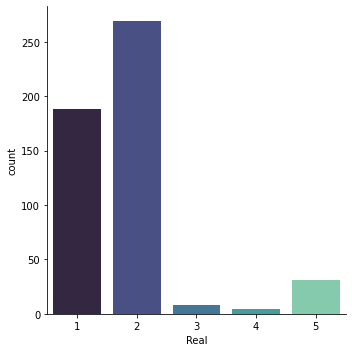

In [ ]:
sns.catplot(x="Real", kind="count", data=y_df, palette="mako")

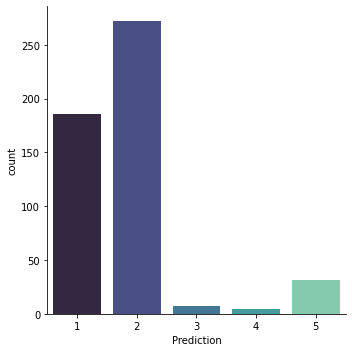

In [ ]:
sns.catplot(x="Prediction", kind="count", data=y_df, palette="mako")

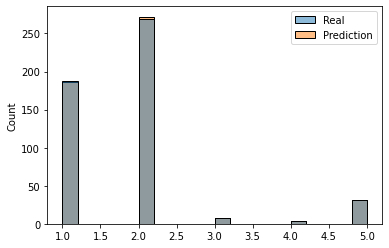

In [ ]:
sns.histplot(data=y_df)

Dari grafik di atas terlihat bahwa nilai prediksinya sudah cukup mendekati aslinya. Setelah ini kita akan gunakan model Random Forest tadi pada data test kita.

##Menggunakan model terbaik tadi untuk memprediksi class dari tiap data test

In [ ]:
test_df.head()

,Sample,Logs
0,54,execve mmap2 cacheflush cacheflush readlink ca...
1,1460,execve brk brk set_tls ioctl ioctl rt_sigprocm...
2,1312,execve ioctl ioctl time getpid time getpid soc...
3,1230,execve ioctl ioctl time getpid time getpid soc...
4,3077,execve brk brk set_tls ioctl ioctl gettimeofda...


In [ ]:
random_forest = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', RandomForestClassifier(n_estimators = 1000))])
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(test_df['Logs'])
Y_pred

array([2, 1, 2, ..., 2, 3, 2])

In [ ]:
test_df['Class'] = Y_pred
test_df.head()

,Sample,Logs,Class
0,54,execve mmap2 cacheflush cacheflush readlink ca...,2
1,1460,execve brk brk set_tls ioctl ioctl rt_sigprocm...,1
2,1312,execve ioctl ioctl time getpid time getpid soc...,2
3,1230,execve ioctl ioctl time getpid time getpid soc...,1
4,3077,execve brk brk set_tls ioctl ioctl gettimeofda...,2


In [ ]:
submission = test_df.drop('Logs', axis=1)

Berikut merupakan dataframe yang berisi Sample dari data test beserta prediksi Class-nya.

In [ ]:
submission

,Sample,Class
0,54,2
1,1460,1
2,1312,2
3,1230,1
4,3077,2
...,...,...
1662,3281,1
1663,824,2
1664,3380,2
1665,1311,3


In [ ]:
labeled_df

,Sample,Class
0,54,2
1,1460,1
2,1312,2
3,1230,1
4,3077,2
...,...,...
1662,3281,1
1663,824,2
1664,3380,2
1665,1311,3


In [ ]:
f1_score_final = f1_score(labeled_df["Class"],submission["Class"], average="macro")*100
f1_score_final

98.53163956299845

In [ ]:
acc_score_final = accuracy_score(labeled_df["Class"],submission["Class"])*100
acc_score_final

98.08038392321535

In [ ]:
submission.to_csv('444033_444052_test.csv', index=False)

##Melihat sebaran data class yang ada pada data test

In [ ]:
submission.groupby('Class')["Sample"].nunique()

Class
1    614
2    907
3     14
4     17
5    115
Name: Sample, dtype: int64

In [ ]:
labeled_df.groupby('Class')["Sample"].nunique()

Class
1    616
2    906
3     14
4     16
5    115
Name: Sample, dtype: int64

In [ ]:
value = submission.groupby('Class')["Sample"].nunique().tolist()
class_x = submission["Class"].value_counts().sort_index().index.tolist()

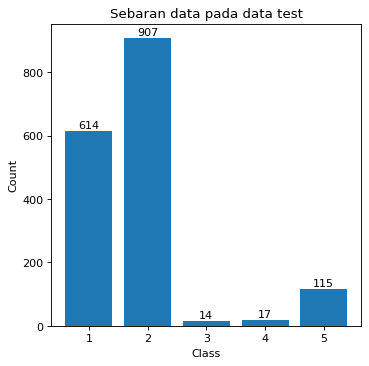

In [ ]:
def labels(x,y):
    for i in range(len(x)):
        plt.text(i+1, y[i]+10, y[i], ha = 'center')
plt.figure(figsize=(5,5), dpi=80)
plt.bar(class_x, value)
labels(class_x, value)
plt.title('Sebaran data pada data test')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Terlihat bahwa Class 2 merupakan yang terbanyak dengan jumlah 907, sedangkan Class 3 merupakan yang paling sedikit dengan jumlah 14.